In [108]:
# MIT image
# Made by : HERO Kwon
# Date : 190108

import os
import numpy as np
import pandas as pd
import pickle
import gzip
import matplotlib.pyplot as plt
import math
import cmath

# data path
#path_meta = '/home/herokwon/mount_data/Data/Wi-Fi_meta/'
#path_csi = '/home/herokwon/mount_data/Data/Wi-Fi_processed/'
#path_csi_np = '/home/herokwon/mount_data/Data/Wi-Fi_processed_npy/'

# data path_mi
path_csi = 'D:\\Data\\Wi-Fi_processed\\'
path_csi_np = 'D:\\Data\\Wi-Fi_processed_npy\\'
path_meta = 'D:\\Data\\Wi-Fi_meta\\'
path_sc = 'D:\\Data\\Wi-Fi_info\\'

# data info
df_info = pd.read_csv(path_meta+'data_subc_sig_v1.csv')
#df_info = df_info[df_info.id_person==107]
person_uid = np.unique(df_info['id_person'])
dict_id = dict(zip(person_uid,np.arange(len(person_uid))))
csi_time = 15000 #int(np.max(df_info['len']))
# parameters
max_value = np.max(df_info['max'].values)
#no_classes = len(np.unique(df_info['id_person']))
no_classes = len(dict_id)
csi_subc = 30
input_shape = (csi_time, csi_subc, 6)

# freq BW list
bw_list = pd.read_csv(path_meta+'wifi_f_bw_list.csv')

# avg Array
with open(path_meta + 'dict_avgcsi.pickle','rb') as f:
    dict_avg = pickle.load(f)


# make data generator
def gen_csi(df_info,dict_avg,id_num,len_num):
    for file in np.unique(df_info.id.values):
        
        # Label
        id_key = df_info[df_info.id==file]['id_person'].values[0].astype('int')
        data1_y = dict_id[id_key]
        
        # read sample data
        # load and uncompress.
        with gzip.open(path_csi+file+'.pickle.gz','rb') as f:
            data1 = pickle.load(f)
            
        # subtract avg
        read_avg = dict_avg[id_key][0]
        nonzero_avg = read_avg[np.nonzero(read_avg)].reshape([-1,30,2,3])
        arr_avg = np.mean(nonzero_avg,axis=0)
        data1_diff = data1 - arr_avg #np.diff(data1,axis=0)
        # zero pad
        pad_len = len_num - data1_diff.shape[0]
        data1_pad = np.pad(data1_diff,((0,pad_len),(0,0),(0,0),(0,0)),'constant',constant_values=0)

        # subcarrier info
        data1_sc_df = pd.read_csv(path_sc + file + '_df_sc.csv')
        data1_time = np.diff(data1_sc_df['timestamp_low'])
        data1_time_pad = np.pad(data1_time,((1,pad_len)),'constant',constant_values=0)
        
        
        yield(data1_pad ,data1_y,id_key,data1_time_pad)


gen = gen_csi(df_info,dict_avg,no_classes,csi_time)
target_sig,target_lab,target_id,target_dt = next(gen)

# 3D scan
m,n = 2,3
c =  299792458 # speed of light 
#r = (160 + 160 + 164) * 0.01 # meter
r = 1.64 #meter
d = 45 * 0.01 # meter
ch = 8#3
max_subc = 3

th_range,si_range = (30,30)
sig_mat = np.zeros([csi_time,2*th_range,2*si_range])

# 3D Reconstruction func
from numba import vectorize
@vectorize(['complex64(complex64,float32,float32,int32,int32,\
float32,float32,float32,int32)'], target='cpu')
def Recon3d(sig,theta,sigma,m,n,lam,d,r,c):
    #above_eq1 = 1j * (2*math.pi) * k * r * t / c
    #above_eq1 = 1j * (2*math.pi) * c * dt * 0.000001 / lam
    above_eq1 = 1j * (2*math.pi) * (160 + 160 + 164) * 0.01 / lam
    above_eq2 = 1j * (2*math.pi/lam) * math.sin(theta) * ((n+1)*d*math.cos(sigma) + (m+1)*d*math.sin(sigma))
    eq_res = sig* cmath.exp(above_eq1) * cmath.exp(above_eq2)
    #eq_res = cmath.exp(above_eq1) * cmath.exp(above_eq2)
    return eq_res #math.atan2(eq_res.imag,eq_res.real)

In [180]:
th_array = np.arange(-th_range,th_range)
si_array = np.arange(-si_range,si_range)
th_array

array([-30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18,
       -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,
        -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
         9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29])

In [167]:
from numba import jit
#@jit
def Calc3d(target_sig,max_subc,theta,sigma,bw_list,ch,d,r,c,m,n):
    m_array = np.concatenate([np.ones(csi_time*n,dtype=np.int32)*0,np.ones(csi_time*n,dtype=np.int32)*1])
    n_array = np.concatenate([np.ones(csi_time*m,dtype=np.int32)*0,np.ones(csi_time*m,dtype=np.int32)*1,np.ones(csi_time*m,dtype=np.int32)*2])
    for subc in range(max_subc): 
        sig1 = np.ascontiguousarray(target_sig[:,subc,:,:].reshape([csi_time*m*n]), dtype=np.complex64)
        lam =  c*0.000001 / bw_list[str(subc)][ch] #wavelength = 300 / frequency in MHz
        sum_eq = np.zeros(csi_time*m*n,dtype=np.complex_)
        sum_eq += Recon3d(sig1,theta,sigma,m_array,n_array,lam,d,r,c)
    sum_reshape = np.sum(sum_eq.reshape([-1,m,n]),axis=(1,2))
    return(np.abs(sum_reshape))

In [168]:
sig_mat = np.zeros([csi_time,2*th_range,2*si_range])
sig_mat.shape

(15000, 60, 60)

In [169]:
for idx_th,i in enumerate(range(-th_range,th_range)):
    for idx_si,j in enumerate(range(-si_range,si_range)):
        theta = i * (np.radians(30)/2) / th_range
        sigma = j * (np.radians(30)/2) / si_range
        sig_mat[:,idx_th,idx_si] = Calc3d(target_sig,max_subc,theta,sigma,bw_list,ch,d,r,c,m,n)

In [189]:
theta_a = ((np.radians(30)/2) / (th_array+0.001)).astype(np.float32)
sigma_a = ((np.radians(30)/2) / (si_array+0.001)).astype(np.float32)
a  = Calc3d(target_sig,max_subc,theta[0],sigma[0],bw_list,ch,d,r,c,m,n)
type(a[0])

numpy.float64

In [191]:
@vectorize(['float64(float32,float32)'], target='cpu')
def calc(theta,sigma):
    return(Calc3d(target_sig,max_subc,theta,sigma,bw_list,ch,d,r,c,m,n))

In [192]:
a = calc(theta_a,sigma_a)

TypeError: bad argument type for built-in operation

In [2]:
from numba import jit
@jit
def Calc3d(target_sig,max_subc,th_range,si_range,bw_list,ch,target_dt,\
          d,r,c):
    # Calc 3D
    for subc in range(max_subc):
        sig1 = target_sig[:,subc,:,:]
        for idx_th,i in enumerate(range(-th_range,th_range)):
            for idx_si,j in enumerate(range(-si_range,si_range)):
                lam =  c*0.000001 / bw_list[str(subc)][ch] #wavelength = 300 / frequency in MHz
                #t = np.arange(1,csi_time+1,1,dtype=np.int32)
                dt = target_dt
                k = 0.0
                theta = i * (np.radians(30)/2) / th_range
                sigma = j * (np.radians(30)/2) / si_range
                sum_eq = np.zeros(csi_time,dtype=np.complex_)
                for m in [0,1]: 
                    for n in [0,1,2]: 
                        #above_eq1 = Calc_Above1(k,r,t,c)
                        sig1 = np.ascontiguousarray(target_sig[:,subc,m,n], dtype=np.complex64)
                        sum_eq += Recon3d(sig1,theta,sigma,m,n,lam,d,k,r,dt,c)
                sig_mat[subc,:,idx_th,idx_si] =  np.abs(sum_eq)
    return(sig_mat)

In [3]:
import time
t1 = time.time()
sig_mat = Calc3d(target_sig,max_subc,th_range,si_range,bw_list,ch,target_dt,\
          d,r,c)
print(time.time()-t1)

78.88677191734314


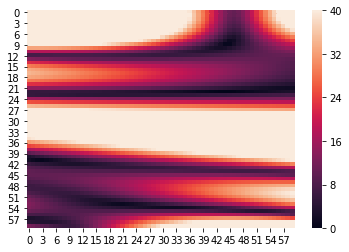

In [25]:
import seaborn as sns
ax = sns.heatmap(sig_mat[0,100,:2*th_range,:2*si_range],vmax=40)

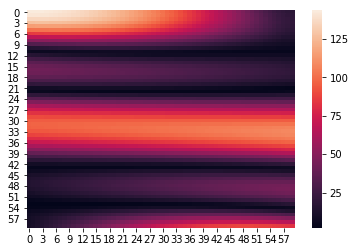

In [5]:
sig_sum = np.mean(sig_mat,axis=0)
ax = sns.heatmap(sig_sum[0,:2*th_range,:2*si_range])#,vmin=np.median(sig_mat))

In [6]:
target_id

17

In [7]:
lam =  c*0.000001 / bw_list[str(14)][8] #wavelength = 300 / frequency in MHz
above_eq1 = 1j * (2*math.pi) * (160 + 160 + 164) * 0.01 / lam
np.median(np.abs(above_eq1))

248.72818050115535

In [8]:
theta,sigma = 10*(np.radians(90)) / th_range,10*(np.radians(90)/2) / th_range
above_eq2 = 1j * (2*math.pi/lam) * math.sin(theta) * ((n+1)*d*math.cos(sigma) + (m+1)*d*math.sin(sigma))
above_eq2

53.65314035284135j

In [9]:
cmath.exp(above_eq2)

(-0.9698783934550549-0.243589617818662j)

In [10]:
np.abs(cmath.exp(above_eq2))

1.0

In [11]:
np.min(c * target_dt*0.000001)

0.0

In [12]:
a = c * target_dt[np.nonzero(target_dt)]* 0.000001
np.min(a)

34176.340211999996

In [13]:
target_dt*0.000001

array([ 0.      ,  0.000762,  0.000713, ...,  0.      ,  0.      ,  0.      ])

In [14]:
np.median(target_dt)

735.0

In [15]:
lam

0.12226446084828711

In [16]:
np.median(np.abs(target_sig))

18.876664945807843

In [17]:
np.abs(cmath.exp(above_eq2))

1.0

In [18]:
np.abs(cmath.exp(np.median(above_eq1)))

1.0

In [19]:
cmath.exp(np.median(above_eq1))

(-0.8564924852039405-0.5161594935571541j)

In [20]:
np.median(np.real(above_eq1))

0.0

In [21]:
np.radians(90)

1.5707963267948966

In [22]:
45*np.cos(np.radians(45))*2

63.63961030678928